Task1. train.csv 파일로 생존자 예측 모델 생성을 위한 분석용 데이터 셋을 작성하세요.

Saving train.csv to train.csv
(712, 10) (179, 10) (712,) (179,)
Accuracy: 0.8212290502793296
Confusion Matrix:
 [[93 12]
 [20 54]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



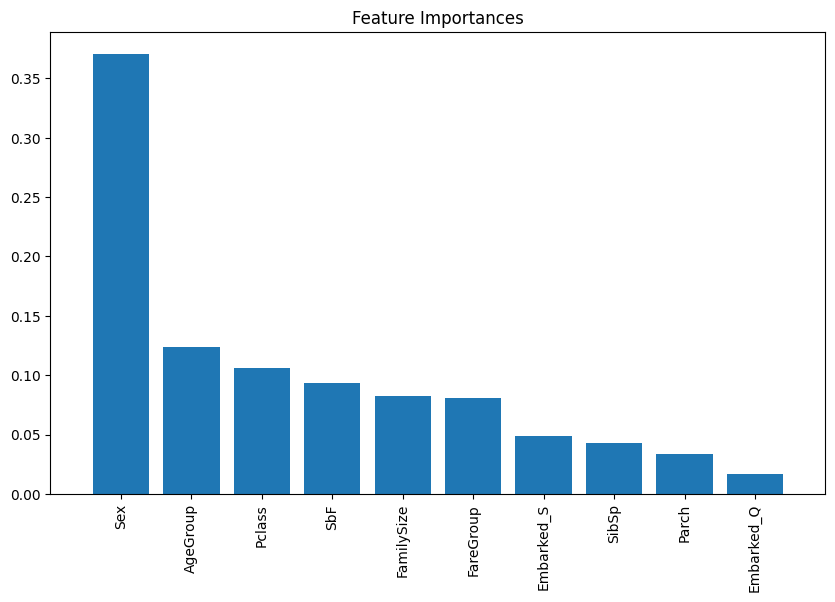

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

########### 데이터 로드

from google.colab import files
uploaded = files.upload()

df = pd.read_csv('train.csv')
# 결측값이 많은 컬럼, 필요없는 컬럼 삭제
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

########### 결측값 처리

# Age 결측값 처리: Sex별 평균 나이로 대체
df['Age'] = df.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.mean()))
# Embarked 결측값 처리: 최빈값으로 대체
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
# Fare 결측값 처리: 중앙값으로 대체
df['Fare'].fillna(df['Fare'].median(), inplace=True)
# 성별을 숫자로 변환
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
# Embarked를 더미 변수로 변환
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

########### 파생 변수 생성

# 가족 규모 변수 생성
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# Age를 범주형 변수로 변환
bins = [0, 5, 12, 18, 35, 60, 100]
labels = [1, 2, 3, 4, 5, 6]
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
df.drop(columns=['Age'], inplace=True)
# Fare를 범주형 변수로 변환
fare_bins = [0, 5, 10, 15, 20, 30, 50, 75, 100, 200, 600]
fare_labels = list(range(1, len(fare_bins)))
df['FareGroup'] = pd.cut(df['Fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)
df.drop(columns=['Fare'], inplace=True)
# FareGroup별 남성의 비율
df['SbF'] = df.groupby('FareGroup')['Sex'].transform('mean')

########## 모델 학습

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

########## 중요 변수 시각화

importances = model.feature_importances_
features = X.columns
indexes = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indexes], align='center')
plt.xticks(range(X.shape[1]), features[indexes], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()